# GPRPy processing workflow
This script contains the basic processing steps to manipulate radar traces using [GPRPy](https://github.com/NSGeophysics/GPRPy/blob/master/gprpy/gprpy.py).  
LID1006.DZT profile was acquired with a 600MHz antenna (IDS)


In [1]:
# Import neccessary modules
import os
import matplotlib.pyplot as plt
import gprpy.gprpy as gp

datadir = '../data/'
fname = 'LID10006.DZT'

{'rh_nsamp': 512, 'rhf_sps': 0.0, 'rhf_spm': 35.71428298950195, 'rhf_position': 0.0, 'rhf_range': 80.0, 'rh_npass': 0, 'rhb_cdt': 0.0}


<Axes: xlabel='profile position [m]', ylabel='time [ns]'>

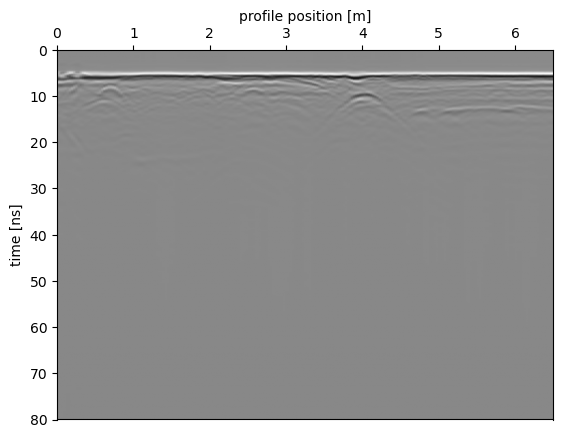

In [2]:
# Initialization
mygpr = gp.gprpyProfile()
data = mygpr.importdata(datadir+fname)

# print trace info
print(mygpr.info)
# show raw profile
mygpr.showProfile()

this is the explanation of what you read: 
- 'rh_nsamp': 512,          # number of samples per trace  
- 'rhf_range': 80.0,        # total time window (ns)  
- 'rhf_spm': 35.7142829895  # number of samples per meter  

### 1. Time-Zero Correction
Aligns the start of each trace so that the first arrival (direct wave) appears at time zero. This compensates for small trigger delays and ensures consistent timing across traces.  
So, we inspect in detail the trace:

<Axes: xlabel='profile position [m]', ylabel='time [ns]'>

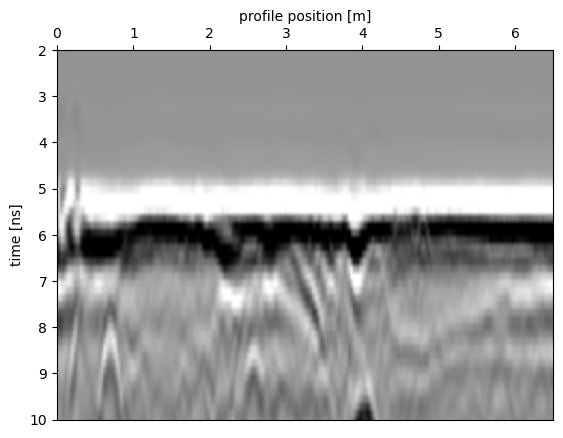

In [3]:
# Check for time-zero
mygpr.showProfile(contrast=2, yrng=[2,10])

<Axes: xlabel='profile position [m]', ylabel='time [ns]'>

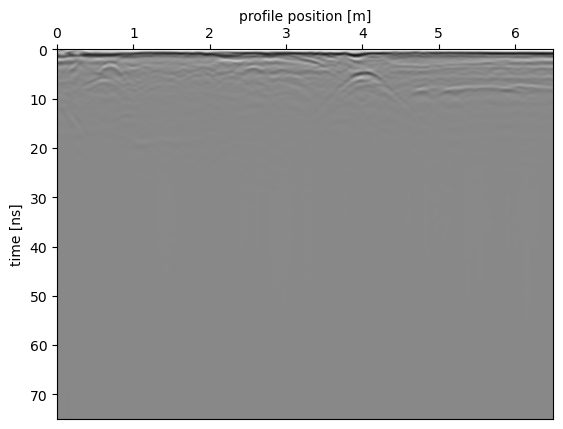

In [4]:
# Set the time-zero
mygpr.setZeroTime(5.0)
mygpr.showProfile()

### 2. Dewow Filtering
Removes low-frequency components caused by the instrument’s electronics or coupling effects. A high-pass or running-average filter is typically applied to restore the signal’s oscillatory character.  
The ready-made GPRpy function `dewow` comes to help:

In [5]:
timewindow = mygpr.info['rhf_range'] * 1e-9  # convert in seconds
n_samples = mygpr.info['rh_nsamp']
dt = timewindow / n_samples
fs = 1 / dt
print(f"dt = {dt:.3e} s  →  fs = {fs/1e9:.2f} GHz")


dt = 1.563e-10 s  →  fs = 6.40 GHz


The recommended time window $T$ for the dewow filter is approximately:

$$
T = \frac{1}{f} \times 150\%
$$

where $f$ is the central frequency of the antenna.

This corresponds to using a moving-average window spanning about 1.5 periods of the dominant frequency component. Such a duration effectively removes the low-frequency "wow" component without distorting the main reflected wavelet.

In [6]:
f0 = 600e6  # Hz
window = int(round(1.5 * fs / f0))
print("Optimal window (samples) =", window)

mygpr.dewow(window) # apply dewow

Optimal window (samples) = 16


100%|██████████████████████████████████████| 465/465 [00:00<00:00, 26825.92it/s]

done with dewow


now we can display in a new plot with adjusted dimensions and different colorscale

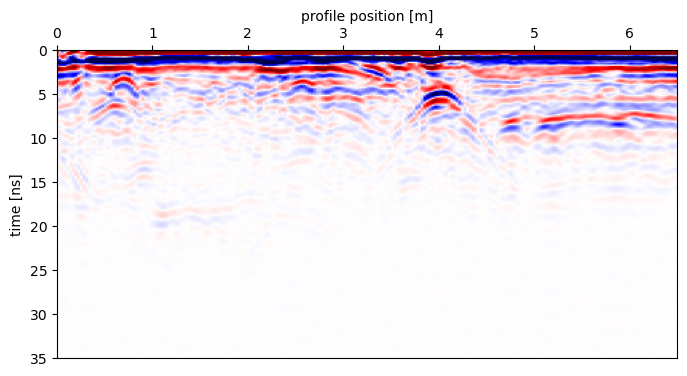

In [7]:
sx = 8
sy = 4

fig = plt.figure(figsize=(sx, sy))
mygpr.showProfile(color='seismic', contrast=2, yrng=[0,35])
plt.show()
fig.tight_layout()

### 4. Gain
Compensates for signal attenuation with depth by amplifying the later parts of each trace. Common approaches include exponential, automatic gain control (AGC), or user-defined gains.
Here we can test:   
- `mygpr.tpowGain` which applies a time-dependent gain proportional to *t^power*, enhancing deeper reflections that are weaker due to attenuation and geometric spreading.  
  Best used when the signal decay with depth is smooth and predictable.  
  Typical values (power = 1–2) for moderate attenuation: start with 1 and increase gradually until deeper layers become visible without saturating the near surface.   
- `mygpr.agcGain` which performs an automatic gain control (AGC) by equalizing the energy of the signal within a moving window (in number of samples).  
  It is ideal when amplitude varies irregularly along the profile, or deeper events are sporadically weak.  
  Typical values (window = 10–80 samples): small windows enhance local contrasts but may distort true amplitudes, while larger windows smooth variations and preserve amplitude balance.



100%|██████████████████████████████████████| 421/421 [00:00<00:00, 32023.98it/s]


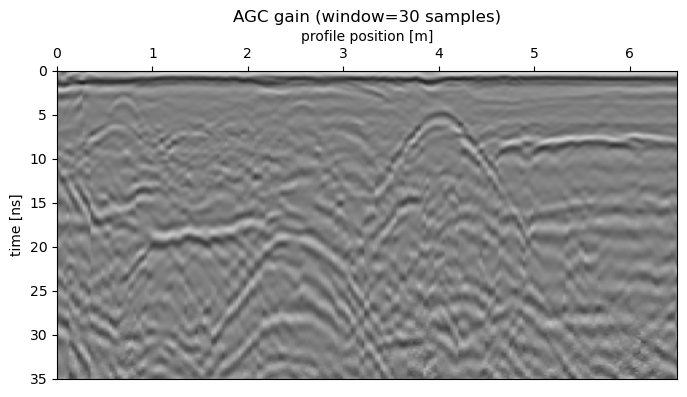

In [8]:
mygpr.agcGain(window=60)
# check
fig = plt.figure(figsize=(sx, sy))
mygpr.showProfile(contrast=1, yrng=[0,35])
plt.title("AGC gain (window=30 samples)")
plt.show()

if you don't like the last processing step applied and you want to remove it, then use:

In [9]:
mygpr.undo()

undo


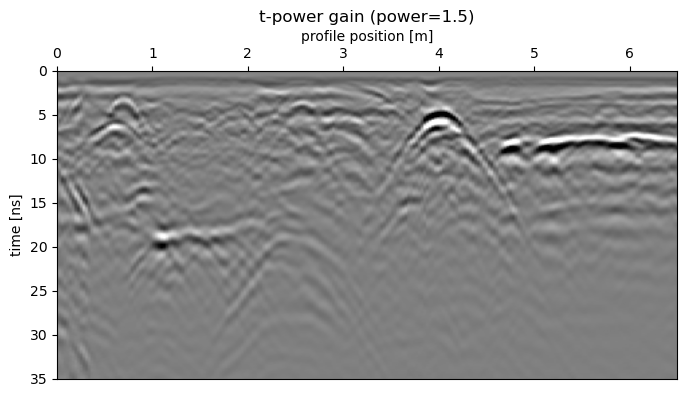

In [10]:
mygpr.tpowGain(power=1.5)
# check
fig = plt.figure(figsize=(sx, sy))
mygpr.showProfile(contrast=2, yrng=[0,35])
plt.title("t-power gain (power=1.5)")
plt.show()

### 5. Time-to-Depth
Converts the vertical axis from two-way travel time (ns) to depth (m) using an estimated/measured EM velocity.  Usually, this is performed by fitting one/some parabolas (i.e. the hyperbolic travel-time response of a point (or small) diffractor) found into the radargram, uscing: 

$$
t(x) \approx t_0 + a\,(x-x_0)^2
$$

then estimate the velocity from 

$$
v = \sqrt{\frac{2}{a\,t_0}}.
$$

Use points near the apex for stability; for large offsets, fit the full hyperbola instead.  
For this function, it is better to launch `GPRpy` and work with the GUI.


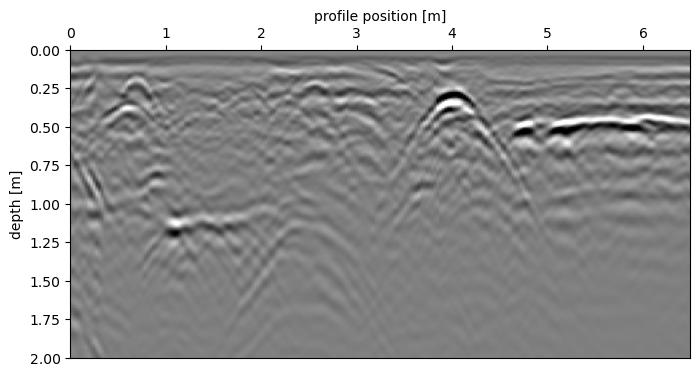

In [11]:
mygpr.setVelocity(0.12)

# Processing check
fig = plt.figure(figsize=(sx, sy))
mygpr.showProfile(color='gray', contrast=2, yrng=[0,2])
plt.show()


**Reference:**
- Daniels, D. J. (2004). *Ground Penetrating Radar (2nd Edition).* IEE Radar, Sonar, Navigation and Avionics Series. (see Chapter 5: *Data Processing – Filtering and Dewowing*)
- Annan, A.P., *Ground penetrating radar theory and applications* (2009). 